### This notebook shows how to use different alignment algorithms to align two samples.

Install hacca library

In [27]:
# use pip to install hacca
%pip install ..

Processing i:\mutiomics\pythonproject
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hacca: filename=hacca-0.0.5-py3-none-any.whl size=16930 sha256=15f0f6d3a13637924e2de8a00f4e1bbb8ca3c419ecf0023ee6e0af69ea4f7962
  Stored in directory: C:\Users\28123\AppData\Local\Temp\pip-ephem-wheel-cache-hos5b3yy\wheels\f4\b6\c3\58ac8cb433abb98add080490f98bd85a3d5a576d67fc039979
Successfully built hacca
  Attempting uninstall: hacca
    Found existing installation: hacca 0.0.5
    Uninstalling hacca-0.0.5:
      Successfully uninstalled hacca-0.0.5
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the necessary libraries

In [1]:
import scanpy as sc
import hacca
from hacca import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from STalign import STalign
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler


i:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


Load dataset. This example shows how to align two samples of `.h5ad` format.
- a_h5ad: sampled from sample A and feature X
- b_prime_h5ad: sampled from sample B and feature Y

And we want to get the alignment result (b_predict) using (a, b_prime) as input.

<img src="../asset/cmparision_notebook_notation.png" width="500">

Note that in this example, sample `A` and `B` are the same, therefore we have `a` equals `b`. So that we can use `a` as `b_truth` to evaluate the alignment performance of `b_predict`.

In [3]:
#### dir name
cwd="I:\\mutiomics\\"
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work_test')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

a_h5ad = sc.read_h5ad(os.path.join(data_path, "O1.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(data_path,"O2.h5ad"))

The `spatial` column saves the raw location information of each cell in the original dataset before scaling and centering. and `clusters` save the cluster ID of each cell.

a AnnData object with n_obs × n_vars = 2000 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden', 'spatialX', 'spatialY'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
b_prime AnnData object with n_obs × n_vars = 2000 × 2499
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


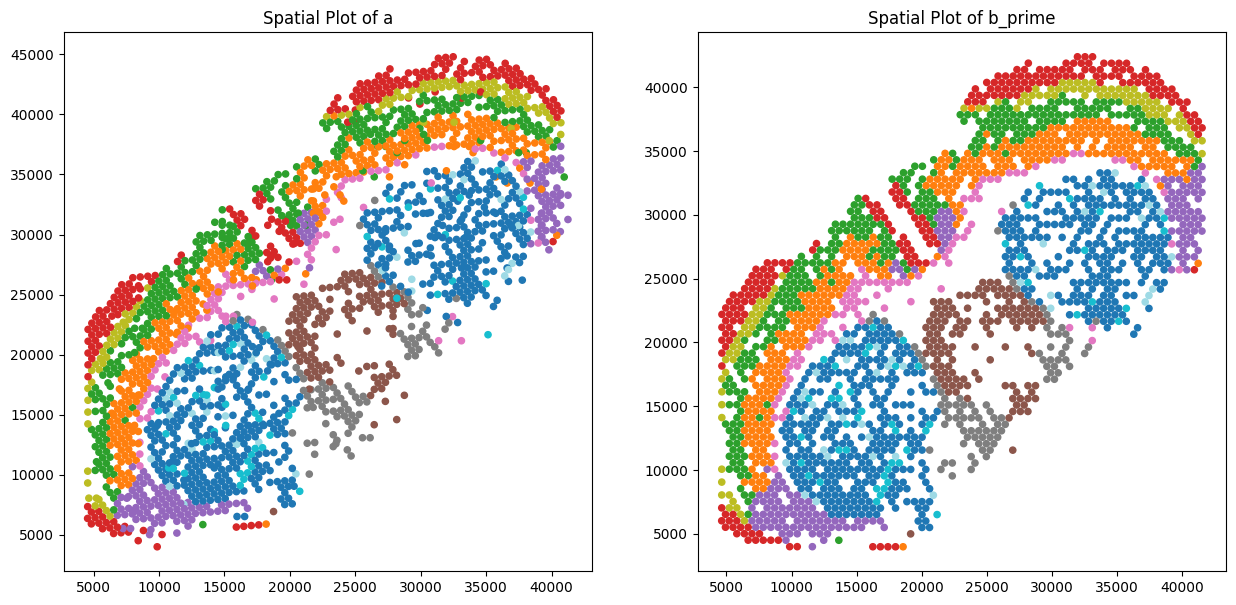

In [4]:
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(a_h5ad.obsm["spatial"][:,0], a_h5ad.obsm["spatial"][:,1], c=a_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1,)
axs[0].set_title('Spatial Plot of a')
axs[1].scatter(b_prime_h5ad.obsm["spatial"][:,0], b_prime_h5ad.obsm["spatial"][:,1], c=b_prime_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

Scale and center the location information of each cell in the original dataset. This step is optional.

In [5]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

Create a `hacca.Data` object from original `.h5ad` files. A `hacca.Data` object is a triple of `(X, D, Label)` where:
- X: the feature matrix of the dataset
- D: the location information of each cell in the dataset
- Label: the cluster information of each cell in the dataset

In [6]:
a =  Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())
b_truth = a # use a as the ground truth to evaluate b_predict.

hacca packages provides the following alignment algorithms:
- manual_gross_alignment: rough alignment by manually providing three pairs of corresponding points
- further_alignment: further alignment by minimizing the distance between the corresponding points
- icp_2d_alignment: Iterative Closest Point (ICP) algorithm for 2D alignment using `data.D` as input
- icp_3d_alignment: Iterative Closest Point (ICP) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.
- fgw_2d_alignment: Fast Global Wasserstein (FGW) algorithm for 2D alignment using `data.D` as input
- fgw_3d_alignment: Fast Global Wasserstein (FGW) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.

Alignment pipeline 1: manual_gross_alignment | further_alignment | icp_3d_alignment | direct_alignment

i:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
i:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
i:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

anchor_points_pairs 9744
unique_anchor_points_pairs 493


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
haCCA loss: (48.31168, 0.95, 0.9018908369569908), pairwise_alignment_accuracy: 0.9474420018401633


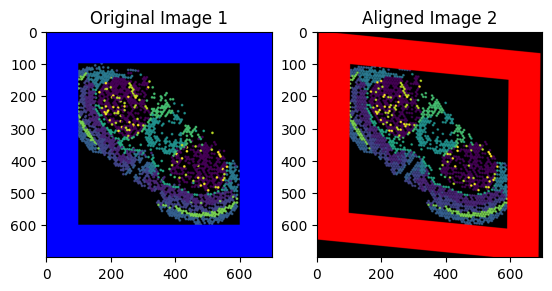

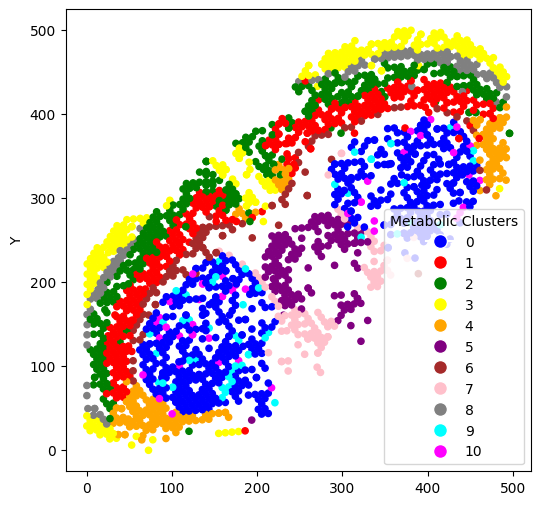

In [7]:
haCCA_work_dir = os.path.join(work_dir, 'haCCA')
if not os.path.exists(haCCA_work_dir):
    os.makedirs(haCCA_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=haCCA_work_dir)
_b_prime = hacca.further_alignment(a, _b_prime)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime)
b_preidct = hacca.direct_alignment(_a, _b_prime, work_dir=haCCA_work_dir)
b_predict_metric = hacca.direct_alignment_metric(_a, _b_prime)
haCCA = hacca.loss(b_preidct, b_truth)
hacca.plot_b_predict(b_preidct,haCCA_work_dir)
hacca_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, b_predict_metric)
print(f"haCCA loss: {haCCA}, pairwise_alignment_accuracy: {hacca_pairwise_alignment_accuracy}")

Alignment pipeline 2: icp_3d_alignment | direct_alignment

anchor_points_pairs 14637
unique_anchor_points_pairs 925


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
ICP 3D: loss: (87.213554, 0.7775, 0.6295326924385118), pairwise_alignment_accuracy: 0.7676714567866872


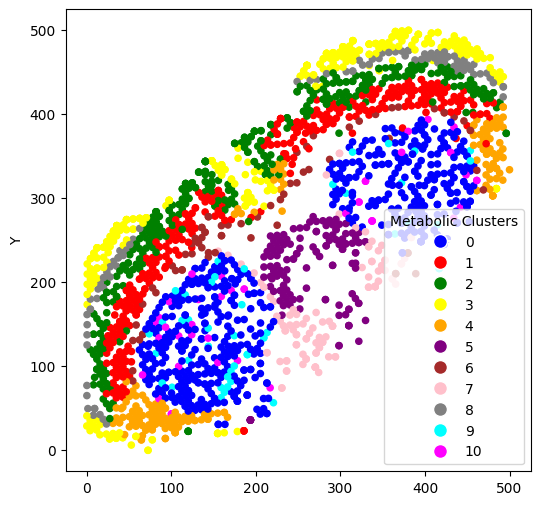

In [8]:
icp_3d_work_dir = os.path.join(work_dir, 'icp_3d')
if not os.path.exists(icp_3d_work_dir):
    os.makedirs(icp_3d_work_dir)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, b_prime, icp_3d_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=icp_3d_work_dir)
b_predict_metric = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, icp_3d_work_dir)
icp_3d_loss = hacca.loss(b_predict, b_truth)
icp_3d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, b_predict_metric)
print(f"ICP 3D: loss: {icp_3d_loss}, pairwise_alignment_accuracy: {icp_3d_pairwise_alignment_accuracy}")

Alignment pipeline 3: fgw_3d_alignment | direct_alignment

anchor_points_pairs 14637
unique_anchor_points_pairs 925


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
FGW 3D: loss: (95.90297, 0.6515, 0.47716510851849975), fgw_3d_pairwise_alignment_accuracy: 0.6490035804364787


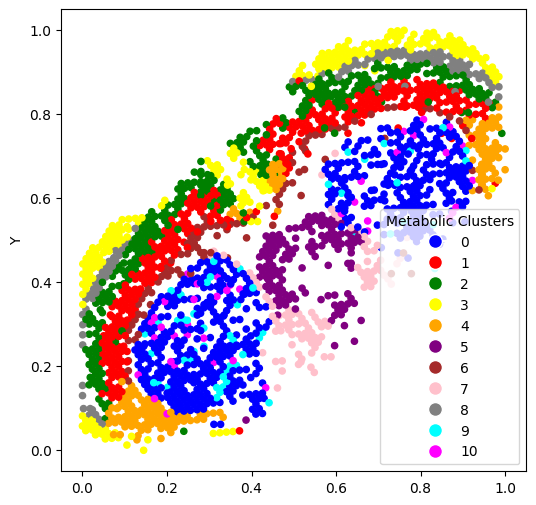

In [9]:
fgw_3d_work_dir = os.path.join(work_dir, 'fgw_3d')
if not os.path.exists(fgw_3d_work_dir):
        os.makedirs(fgw_3d_work_dir)
_a, _b_prime = hacca.fgw_3d_alignment(a, b_prime, fgw_3d_work_dir, alpha=0.8)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=fgw_3d_work_dir)
pi = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, fgw_3d_work_dir)
fgw_3d_loss = hacca.loss(b_predict, b_truth)
fgw_3d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, pi)
print(f"FGW 3D: loss: {fgw_3d_loss}, fgw_3d_pairwise_alignment_accuracy: {fgw_3d_pairwise_alignment_accuracy}")

Alignment pipeline 4: fgw_2d_alignment | direct_alignment

FGW 2D: loss: (83.710724, 0.8025, 0.6673771733264706), pairwise_alignment_accuracy: 0.7985601623616042


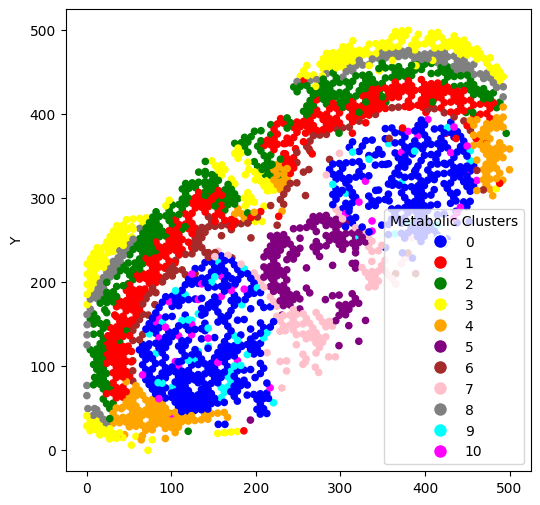

In [10]:
fgw_2d_work_dir = os.path.join(work_dir, 'fgw_2d')
if not os.path.exists(fgw_2d_work_dir):
        os.makedirs(fgw_2d_work_dir)
_b_prime = hacca.fgw_2d_alignment(a, b_prime, fgw_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=fgw_2d_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
hacca.plot_b_predict(b_predict, fgw_2d_work_dir)
fgw_2d_loss = hacca.loss(b_predict, b_truth)
fgw_2d_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"FGW 2D: loss: {fgw_2d_loss}, pairwise_alignment_accuracy: {fgw_2d_pairwise_alignment_accuracy}")

Alignment pipeline 5: icp_2d_alignment | direct_alignment

Converged after 32 iterations.
ICP 2D: loss: (89.99773, 0.7655, 0.6107027476275826), pairwise_alignment_accuracy: 0.7559412138139665


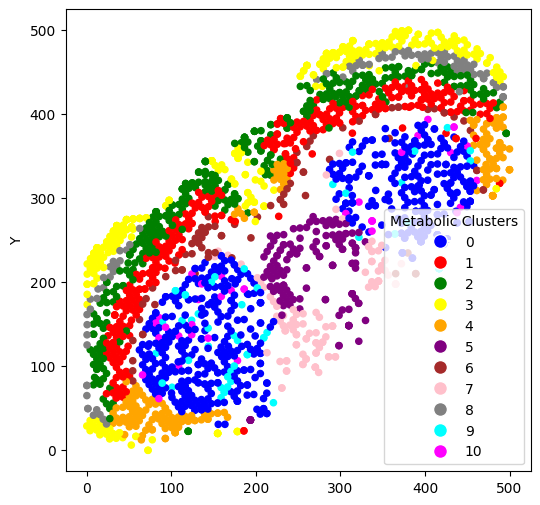

In [11]:
icp_2d_work_dir = os.path.join(work_dir, 'icp_2d')
if not os.path.exists(icp_2d_work_dir):
    os.makedirs(icp_2d_work_dir)

_b_prime = hacca.icp_2d_alignment(a, b_prime, icp_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=icp_2d_work_dir)
hacca.plot_b_predict(b_predict, icp_2d_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
icp_2d_loss = hacca.loss(b_predict, b_truth)
icp_2d_dir_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"ICP 2D: loss: {icp_2d_loss}, pairwise_alignment_accuracy: {icp_2d_dir_pairwise_alignment_accuracy}")

Alignment pipeline 6: direct_alignment

Direct alignment w/ center and scale: loss: (90.381744, 0.7545, 0.5912446218882244), pairwise_alignment_accuracy: 0.7609311485637373


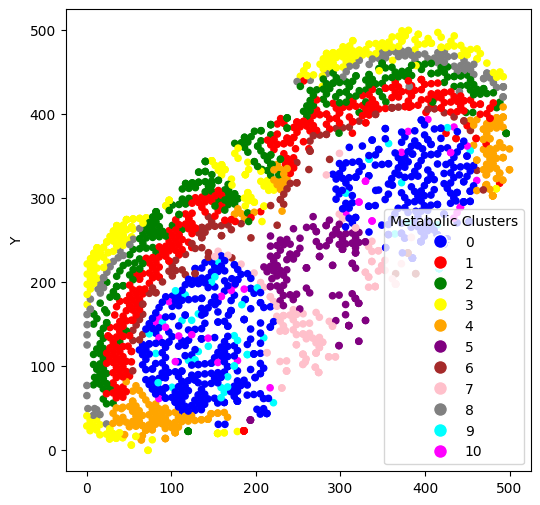

In [12]:
direct_alignment_work_dir = os.path.join(work_dir, 'direct_alignment')
if not os.path.exists(direct_alignment_work_dir):
    os.makedirs(direct_alignment_work_dir)
    
b_predict = hacca.direct_alignment(a, b_prime, direct_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, b_prime)
hacca.plot_b_predict(b_predict, direct_alignment_work_dir)
direct_alignment_loss = hacca.loss(b_predict, b_truth)
direct_alignment_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, b_prime, pi)
print(f"Direct alignment w/ center and scale: loss: {direct_alignment_loss}, pairwise_alignment_accuracy: {direct_alignment_pairwise_alignment_accuracy}")

Alignment pipeline 7: manual_gross_alignment | direct_alignment

manual_alignment: loss: (64.87801, 0.8825, 0.7847758544820906), pairwise_alignment_accuracy: 0.8719091701662041


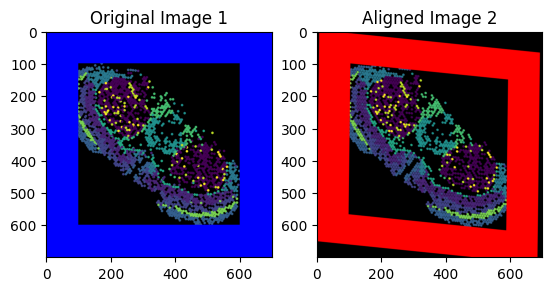

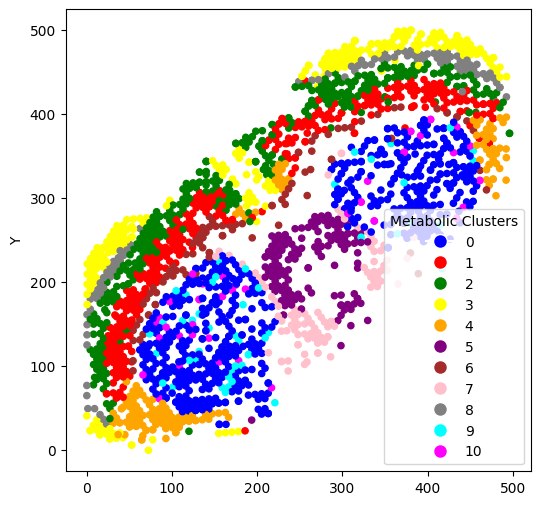

In [13]:
manual_alignment_work_dir = os.path.join(work_dir, 'manual alignment')
if not os.path.exists(manual_alignment_work_dir):
    os.makedirs(manual_alignment_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_alignment_work_dir)
b_preidct = hacca.direct_alignment(a, _b_prime, work_dir=manual_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
manual_alignment = hacca.loss(b_preidct, b_truth)
manual_alignment_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"manual_alignment: loss: {manual_alignment}, pairwise_alignment_accuracy: {manual_alignment_pairwise_alignment_accuracy}")
hacca.plot_b_predict(b_preidct,manual_alignment_work_dir)

Alignment pipeline 8: icp_3d_alignment | fgw_3d_alignment | direct_alignment

anchor_points_pairs 10784
unique_anchor_points_pairs 484


i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
i:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
Run ICP2D_FGW3D alignment: loss: (83.701744, 0.8015, 0.6655784660145772), pairwise_alignment_accuracy: 0.798535744890194


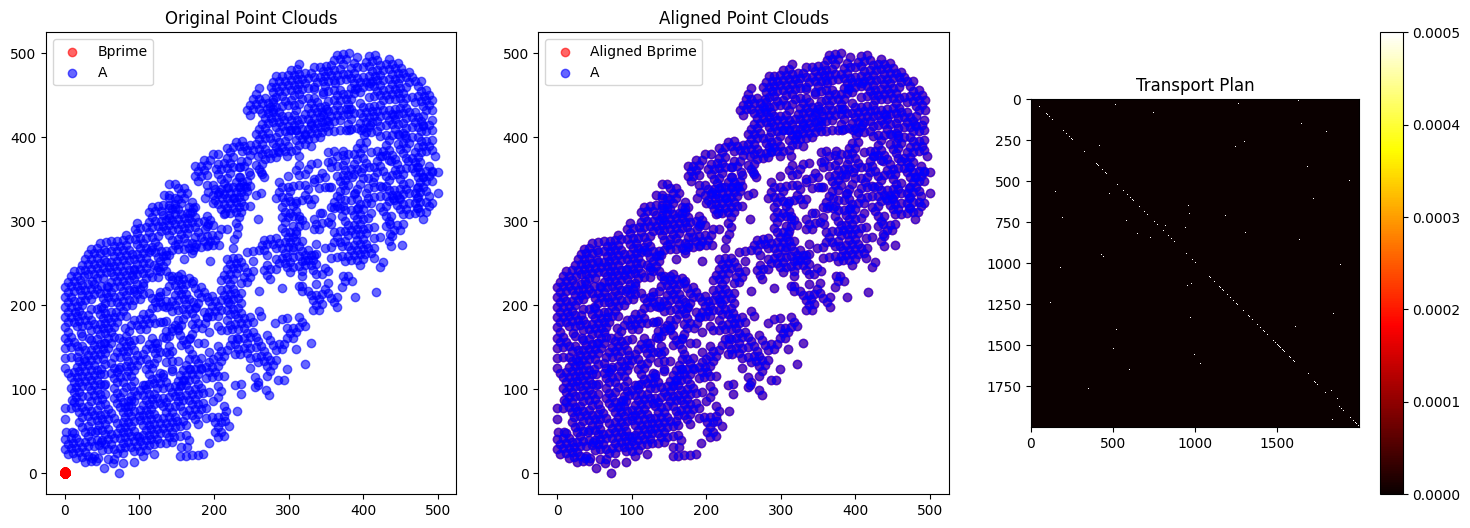

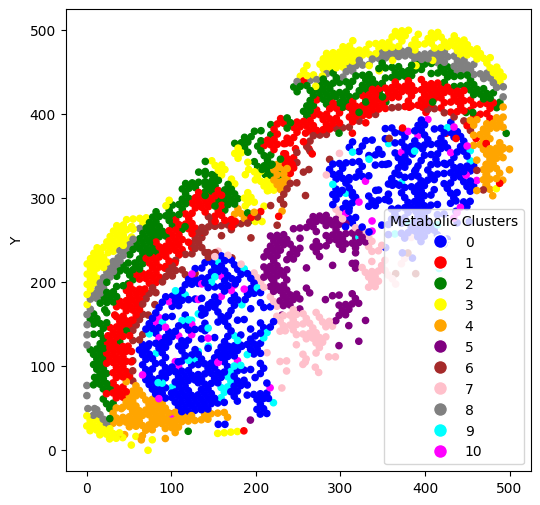

In [14]:
ICP2D_FGW3D_alignment_work_dir = os.path.join(work_dir, 'ICP2D_FGW3D')
if not os.path.exists(ICP2D_FGW3D_alignment_work_dir):
    os.makedirs(ICP2D_FGW3D_alignment_work_dir)
    
_b_prime = hacca.fgw_2d_alignment(a, b_prime, ICP2D_FGW3D_alignment_work_dir)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
pi = hacca.direct_alignment_metric(_a, _b_prime)
hacca.plot_b_predict(b_predict, ICP2D_FGW3D_alignment_work_dir)
ICD2D_FGW3D_alignment_loss = hacca.loss(b_predict, b_truth)
ICD2D_FGW3D_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, pi)
print(f"Run ICP2D_FGW3D alignment: loss: {ICD2D_FGW3D_alignment_loss}, pairwise_alignment_accuracy: {ICD2D_FGW3D_pairwise_alignment_accuracy}")

Alignment pipeline 9: STalign

0 of 2000
1999 of 2000
0 of 2000
1999 of 2000


i:\mutiomics\pythonProject\.venv\lib\site-packages\STalign\STalign.py:1043: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
i:\mutiomics\pythonProject\.venv\lib\site-packages\STalign\STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
i:\mutiomics\pythonProject\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Run STalign_alignment: loss: (89.45141, 0.774, 0.6229017743910479), pairwise_alignment_accuracy: 0.7607830741286936


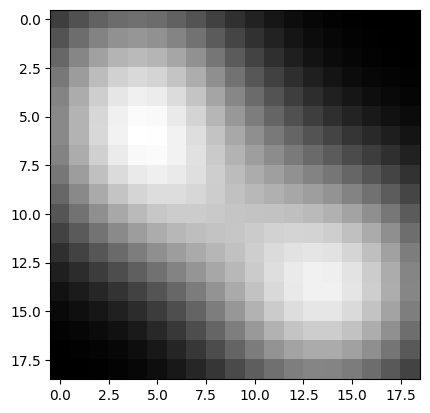

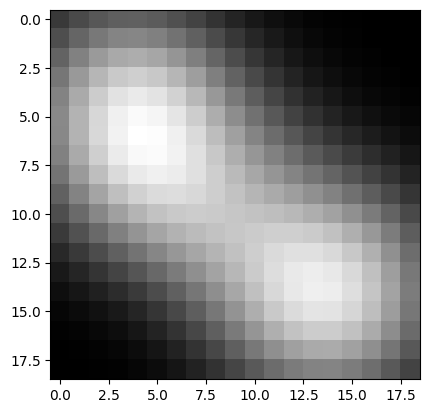

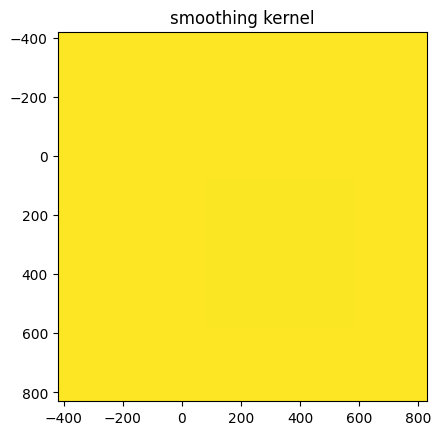

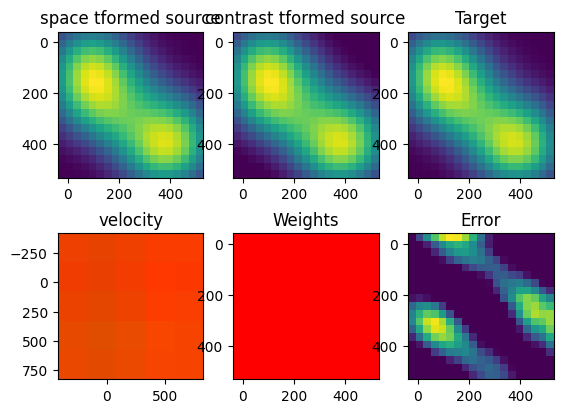

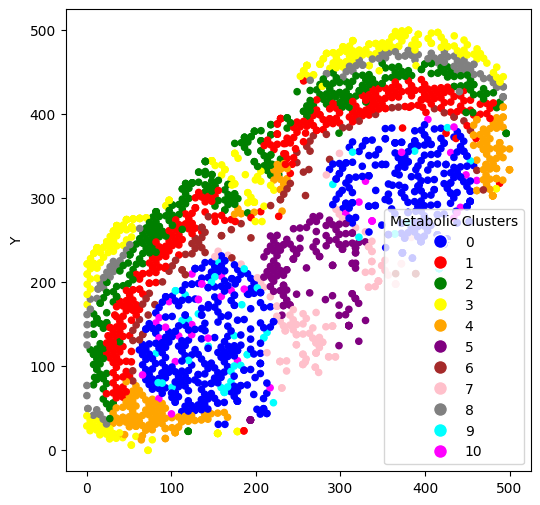

In [17]:
STalign_alignment_work_dir = os.path.join(work_dir, 'STalign')
if not os.path.exists(STalign_alignment_work_dir):
    os.makedirs(STalign_alignment_work_dir)
_b_prime = STAlign_process(a,b_prime)
b_predict = hacca.direct_alignment(a, _b_prime, STalign_alignment_work_dir)
pi = hacca.direct_alignment_metric(a, _b_prime)
hacca.plot_b_predict(b_predict, STalign_alignment_work_dir)
STalign_alignment_loss = hacca.loss(b_predict, b_truth)
STalign_pairwise_alignment_accuracy = hacca.pairwise_alignment_accuracy(a, _b_prime, pi)
print(f"Run STalign_alignment: loss: {STalign_alignment_loss}, pairwise_alignment_accuracy: {STalign_pairwise_alignment_accuracy}")

In [16]:
def STAlign_process(a,b_prime):
    import matplotlib.pyplot as plt
    xJ = a.D[:, 0]
    yJ = a.D[:, 1]
    xI = b_prime.D[:, 0]
    yI = b_prime.D[:, 1]
    XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30,blur=1.5)
    XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=30, blur=1.5)
    extentI = STalign.extent_from_x((YI,XI))
    extentJ = STalign.extent_from_x((YJ,XJ))
    # run LDDMM
    # specify device (default device for STalign.LDDMM is cpu)
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    # keep all other parameters default
    params = {
                'niter': 1000,
                'device':device,
                'epV': 50
              }
    
    out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)
    # get necessary output variables
    A = out['A']
    v = out['v']
    xv = out['xv']
    # set device for building tensors
    if torch.cuda.is_available():
        torch.set_default_device('cuda:0')
    else:
        torch.set_default_device('cpu')
        # apply transform
    phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
    phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
    
    #switch tensor from cuda to cpu for plotting with numpy
    if phii.is_cuda:
        phii = phii.cpu()
    if phiI.is_cuda:
        phiI = phiI.cpu()
    # transform is invertible
    phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
    phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])
    
    #switch tensor from cuda to cpu for plotting with numpy
    if phi.is_cuda:
        phi = phi.cpu()
    if phiiJ.is_cuda:
        phiiJ = phiiJ.cpu()
    # apply transform to original points
    tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1).astype(np.double))
    
    #switch tensor from cuda to cpu for plotting with numpy
    if tpointsI.is_cuda:
        tpointsI = tpointsI.cpu()
    
    #switch from row column coordinates (y,x) to (x,y)
    xI_LDDMM = tpointsI[:,1]
    yI_LDDMM = tpointsI[:,0]
    df3 = pd.DataFrame(
    
        {
    
            "x": xI_LDDMM,
    
            "y": yI_LDDMM,
           
        },
    
    )
    b_prime.D=df3.to_numpy()
   

    return b_prime


Let's compare the performance of these alignment algorithms (alignment pieplines 1-8)

In [18]:
print(f"haCCA: loss: {haCCA}, pairwise_alignment_accuracy: {hacca_pairwise_alignment_accuracy}")
print(f"FWG2D-ICP3D alignment: loss: {ICD2D_FGW3D_alignment_loss}, pairwise_alignment_accuracy: {ICD2D_FGW3D_pairwise_alignment_accuracy}")
print(f"manual_alignment: loss: {manual_alignment}, pairwise_alignment_accuracy: {manual_alignment_pairwise_alignment_accuracy}")
print(f"Direct alignment: loss: {direct_alignment_loss}, pairwise_alignment_accuracy: {direct_alignment_pairwise_alignment_accuracy}")
print(f"ICP 2D: loss: {icp_2d_loss}, pairwise_alignment_accuracy: {icp_2d_dir_pairwise_alignment_accuracy}")
print(f"FGW 2D: loss: {fgw_2d_loss}, pairwise_alignment_accuracy: {fgw_2d_pairwise_alignment_accuracy}")
print(f"FGW 3D: loss: {fgw_3d_loss}, pairwise_alignment_accuracy: {fgw_3d_pairwise_alignment_accuracy}")
print(f"ICP 3D: loss: {icp_3d_loss}, pairwise_alignment_accuracy: {icp_3d_pairwise_alignment_accuracy}")
print(f"STalign_alignment: loss: {STalign_alignment_loss}, pairwise_alignment_accuracy: {STalign_pairwise_alignment_accuracy}")

haCCA: loss: (48.31168, 0.95, 0.9018908369569908), pairwise_alignment_accuracy: 0.9474420018401633
FWG2D-ICP3D alignment: loss: (83.701744, 0.8015, 0.6655784660145772), pairwise_alignment_accuracy: 0.798535744890194
manual_alignment: loss: (64.87801, 0.8825, 0.7847758544820906), pairwise_alignment_accuracy: 0.8719091701662041
Direct alignment: loss: (90.381744, 0.7545, 0.5912446218882244), pairwise_alignment_accuracy: 0.7609311485637373
ICP 2D: loss: (89.99773, 0.7655, 0.6107027476275826), pairwise_alignment_accuracy: 0.7559412138139665
FGW 2D: loss: (83.710724, 0.8025, 0.6673771733264706), pairwise_alignment_accuracy: 0.7985601623616042
FGW 3D: loss: (95.90297, 0.6515, 0.47716510851849975), pairwise_alignment_accuracy: 0.6490035804364787
ICP 3D: loss: (87.213554, 0.7775, 0.6295326924385118), pairwise_alignment_accuracy: 0.7676714567866872
STalign_alignment: loss: (89.45141, 0.774, 0.6229017743910479), pairwise_alignment_accuracy: 0.7607830741286936
